Plant Disease Classification Using Convolutional Neural Network

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from skimage.transform import resize
from IPython import embed
from keras.optimizers import Adamax
from keras import regularizers
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Data reading
DATADIR = "E:/tomato_plant_disease" #directory of dataset
CATEGORIES = ["Healthy","Septoria_leaf_spot","Spider_mites","Target_Spot"] #types of plant disease

IMG_SIZE = 224 #resize the image

#create data array
data_array = []

def create_data_array():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            

create_data_array()

print(len(data_array))



100%|█████████████████████████████████████████████████████████████████████████████| 1404/1404 [00:06<00:00, 213.69it/s]

6442


In [4]:
%%time
#random the dataset
random.shuffle(training_data)
    
#dataset
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X_data =np.array(X) # to change array to know shape
Y_data =np.array(y)

#splitting training set(80%) and test set(20%) 
x_train, x_test, y_train, y_test  = train_test_split(X_data, Y_data, test_size=0.2)
print(x_train.shape)
print(y_train.shape)


(5153, 224, 224, 3)
(5153,)
Wall time: 812 ms


Classification Using Pretrained Model

In [5]:
NUM_CLASSES = 4 # Number of class
BATCH_SIZE = 16
NUM_EPOCHS = 10

y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
print("the shape of testset ",y_test.shape)
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print("The shape of train set after normalization ",y_train.shape)

K.set_learning_phase(1)

base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
#predict 4 classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# initiate Adamax optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(lr=0.002, beta_1=0.9, beta_2=0.999),
              metrics=['acc'])

callbacks = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3) #to quit when the model start to overfit
checkpoint = ModelCheckpoint("detection.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.summary()



the shape of testset  (1289, 4)
The shape of train set after normalization  (5153, 4)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______

In [7]:
%%time

datagen = ImageDataGenerator(
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
H= model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=BATCH_SIZE),
                        epochs=NUM_EPOCHS,
                        verbose=2,
                        callbacks= [callbacks,checkpoint],
                        validation_data=(x_test, y_test),
                        workers=1)

Epoch 1/10
 - 2076s - loss: 1.0652 - acc: 0.8548 - val_loss: 0.6569 - val_acc: 0.9527

Epoch 00001: val_acc improved from -inf to 0.95268, saving model to detection.h5
Epoch 2/10
 - 1929s - loss: 0.6268 - acc: 0.9455 - val_loss: 0.4924 - val_acc: 0.9628

Epoch 00002: val_acc improved from 0.95268 to 0.96276, saving model to detection.h5
Epoch 3/10
 - 1877s - loss: 0.4307 - acc: 0.9635 - val_loss: 0.3439 - val_acc: 0.9752

Epoch 00003: val_acc improved from 0.96276 to 0.97517, saving model to detection.h5
Epoch 4/10
 - 1845s - loss: 0.3013 - acc: 0.9742 - val_loss: 0.2760 - val_acc: 0.9721

Epoch 00004: val_acc did not improve from 0.97517
Epoch 5/10
 - 2122s - loss: 0.2447 - acc: 0.9728 - val_loss: 0.3049 - val_acc: 0.9434

Epoch 00005: val_acc did not improve from 0.97517
Epoch 6/10
 - 2460s - loss: 0.2025 - acc: 0.9705 - val_loss: 0.2245 - val_acc: 0.9620

Epoch 00006: val_acc did not improve from 0.97517
Epoch 7/10
 - 2047s - loss: 0.1497 - acc: 0.9829 - val_loss: 0.1498 - val_acc: 

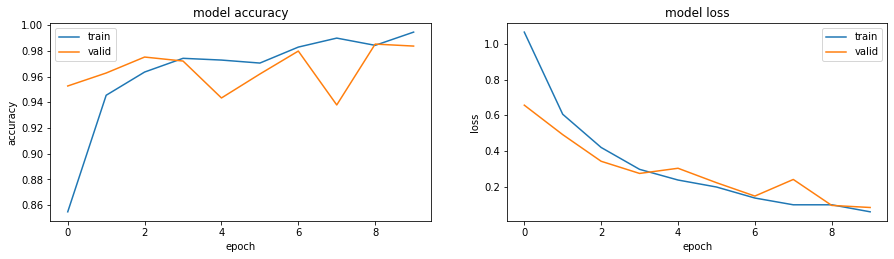

Accuracy
1289/1289 [==============================] - 137s 107ms/step
Train Loss: 0.04842045481589473
Test Loss: 0.07244748871880413
Train F1 Score: 0.9967009425163269
Test F1 Score: 0.9906904697418213
Wall time: 11min 11s


In [8]:
%%time

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(H.history['acc'])  
plt.plot(H.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(H.history['loss'])  
plt.plot(H.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

print("Accuracy")
#model.load_weights('model.h5')
train_loss, train_score = model.evaluate(x_train, y_train)
test_loss, test_score = model.evaluate(x_test, y_test)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Train F1 Score:", train_score)
print("Test F1 Score:", test_score)




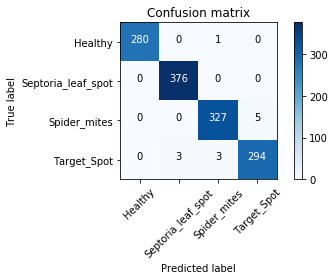

In [13]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
predictions = model.predict(x_test)
y_pred = (predictions > 0.5)
#y_pred = keras.utils.to_categorical(y_pred, NUM_CLASSES)
cnf_matrix = confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Healthy","Septoria_leaf_spot","Spider_mites","Target_Spot"],
                      title='Confusion matrix')


In [11]:
print(classification_report(y_test, y_pred, target_names=["Healthy","Septoria_leaf_spot","Spider_mites","Target_Spot"]))

                    precision    recall  f1-score   support

           Healthy       1.00      1.00      1.00       281
Septoria_leaf_spot       0.99      1.00      1.00       376
      Spider_mites       0.99      0.98      0.99       332
       Target_Spot       0.98      0.98      0.98       300

         micro avg       0.99      0.99      0.99      1289
         macro avg       0.99      0.99      0.99      1289
      weighted avg       0.99      0.99      0.99      1289
       samples avg       0.99      0.99      0.99      1289

